## Purpose:

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise data and determine the best pre-processing;
- to create the necessary datasets for training and testing purposes;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled 300 samples for you, which is all they have at the moment.

## 1. Investigate Dataset

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

### 1.1 Load the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    object 
 1   mean radius              300 non-null    float64
 2   mean texture             300 non-null    float64
 3   mean perimeter           300 non-null    float64
 4   mean area                300 non-null    float64
 5   mean smoothness          300 non-null    float64
 6   mean compactness         300 non-null    float64
 7   mean concavity           300 non-null    float64
 8   mean concave points      300 non-null    float64
 9   mean symmetry            300 non-null    float64
 10  mean fractal dimension   300 non-null    float64
 11  radius error             300 non-null    float64
 12  texture error            300 non-null    float64
 13  perimeter error          300 non-null    float64
 14  area error               3

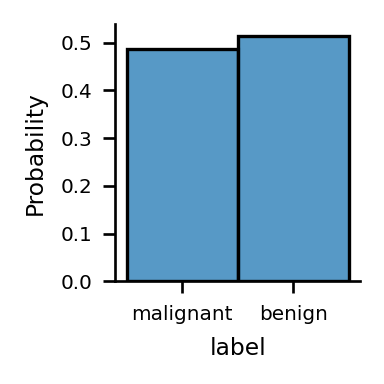

In [2]:
# Load the data
df = pd.read_csv("assignment2.csv")

# Display the data
df.head()

# Summarise the data with pandas function 1
# Shows the data-tyoe and non-missing value count for each column.
df.info()
print()

# Summarise the data with pandas function 2
# Shows the spread and behaviour of the each column like mean, median, quantiles, min-max etcetera.
print("Information of range of the values in dataset.")
print(df.describe())
print()

# Graphically show the proportions of the labels using stat.
print("Graphical representation of proportions of labels.")
sns.displot(df["label"],kind="hist",stat="probability",height=1.7)

### 1.2 Visualise the dataset

In [3]:
# Code fragment to help with plotting histograms combining matplotlib and seaborn (and pandas)
#fig, axes = plt.subplots(Nrows, Ncols, figsize=(?, ?))
#...
#sns.histplot(data=df, x=??, hue="??", bins=??, kde=True, ax=axes[row,col], edgecolor=None)

Histograms of Mean group, having two claases displayed in one plot.


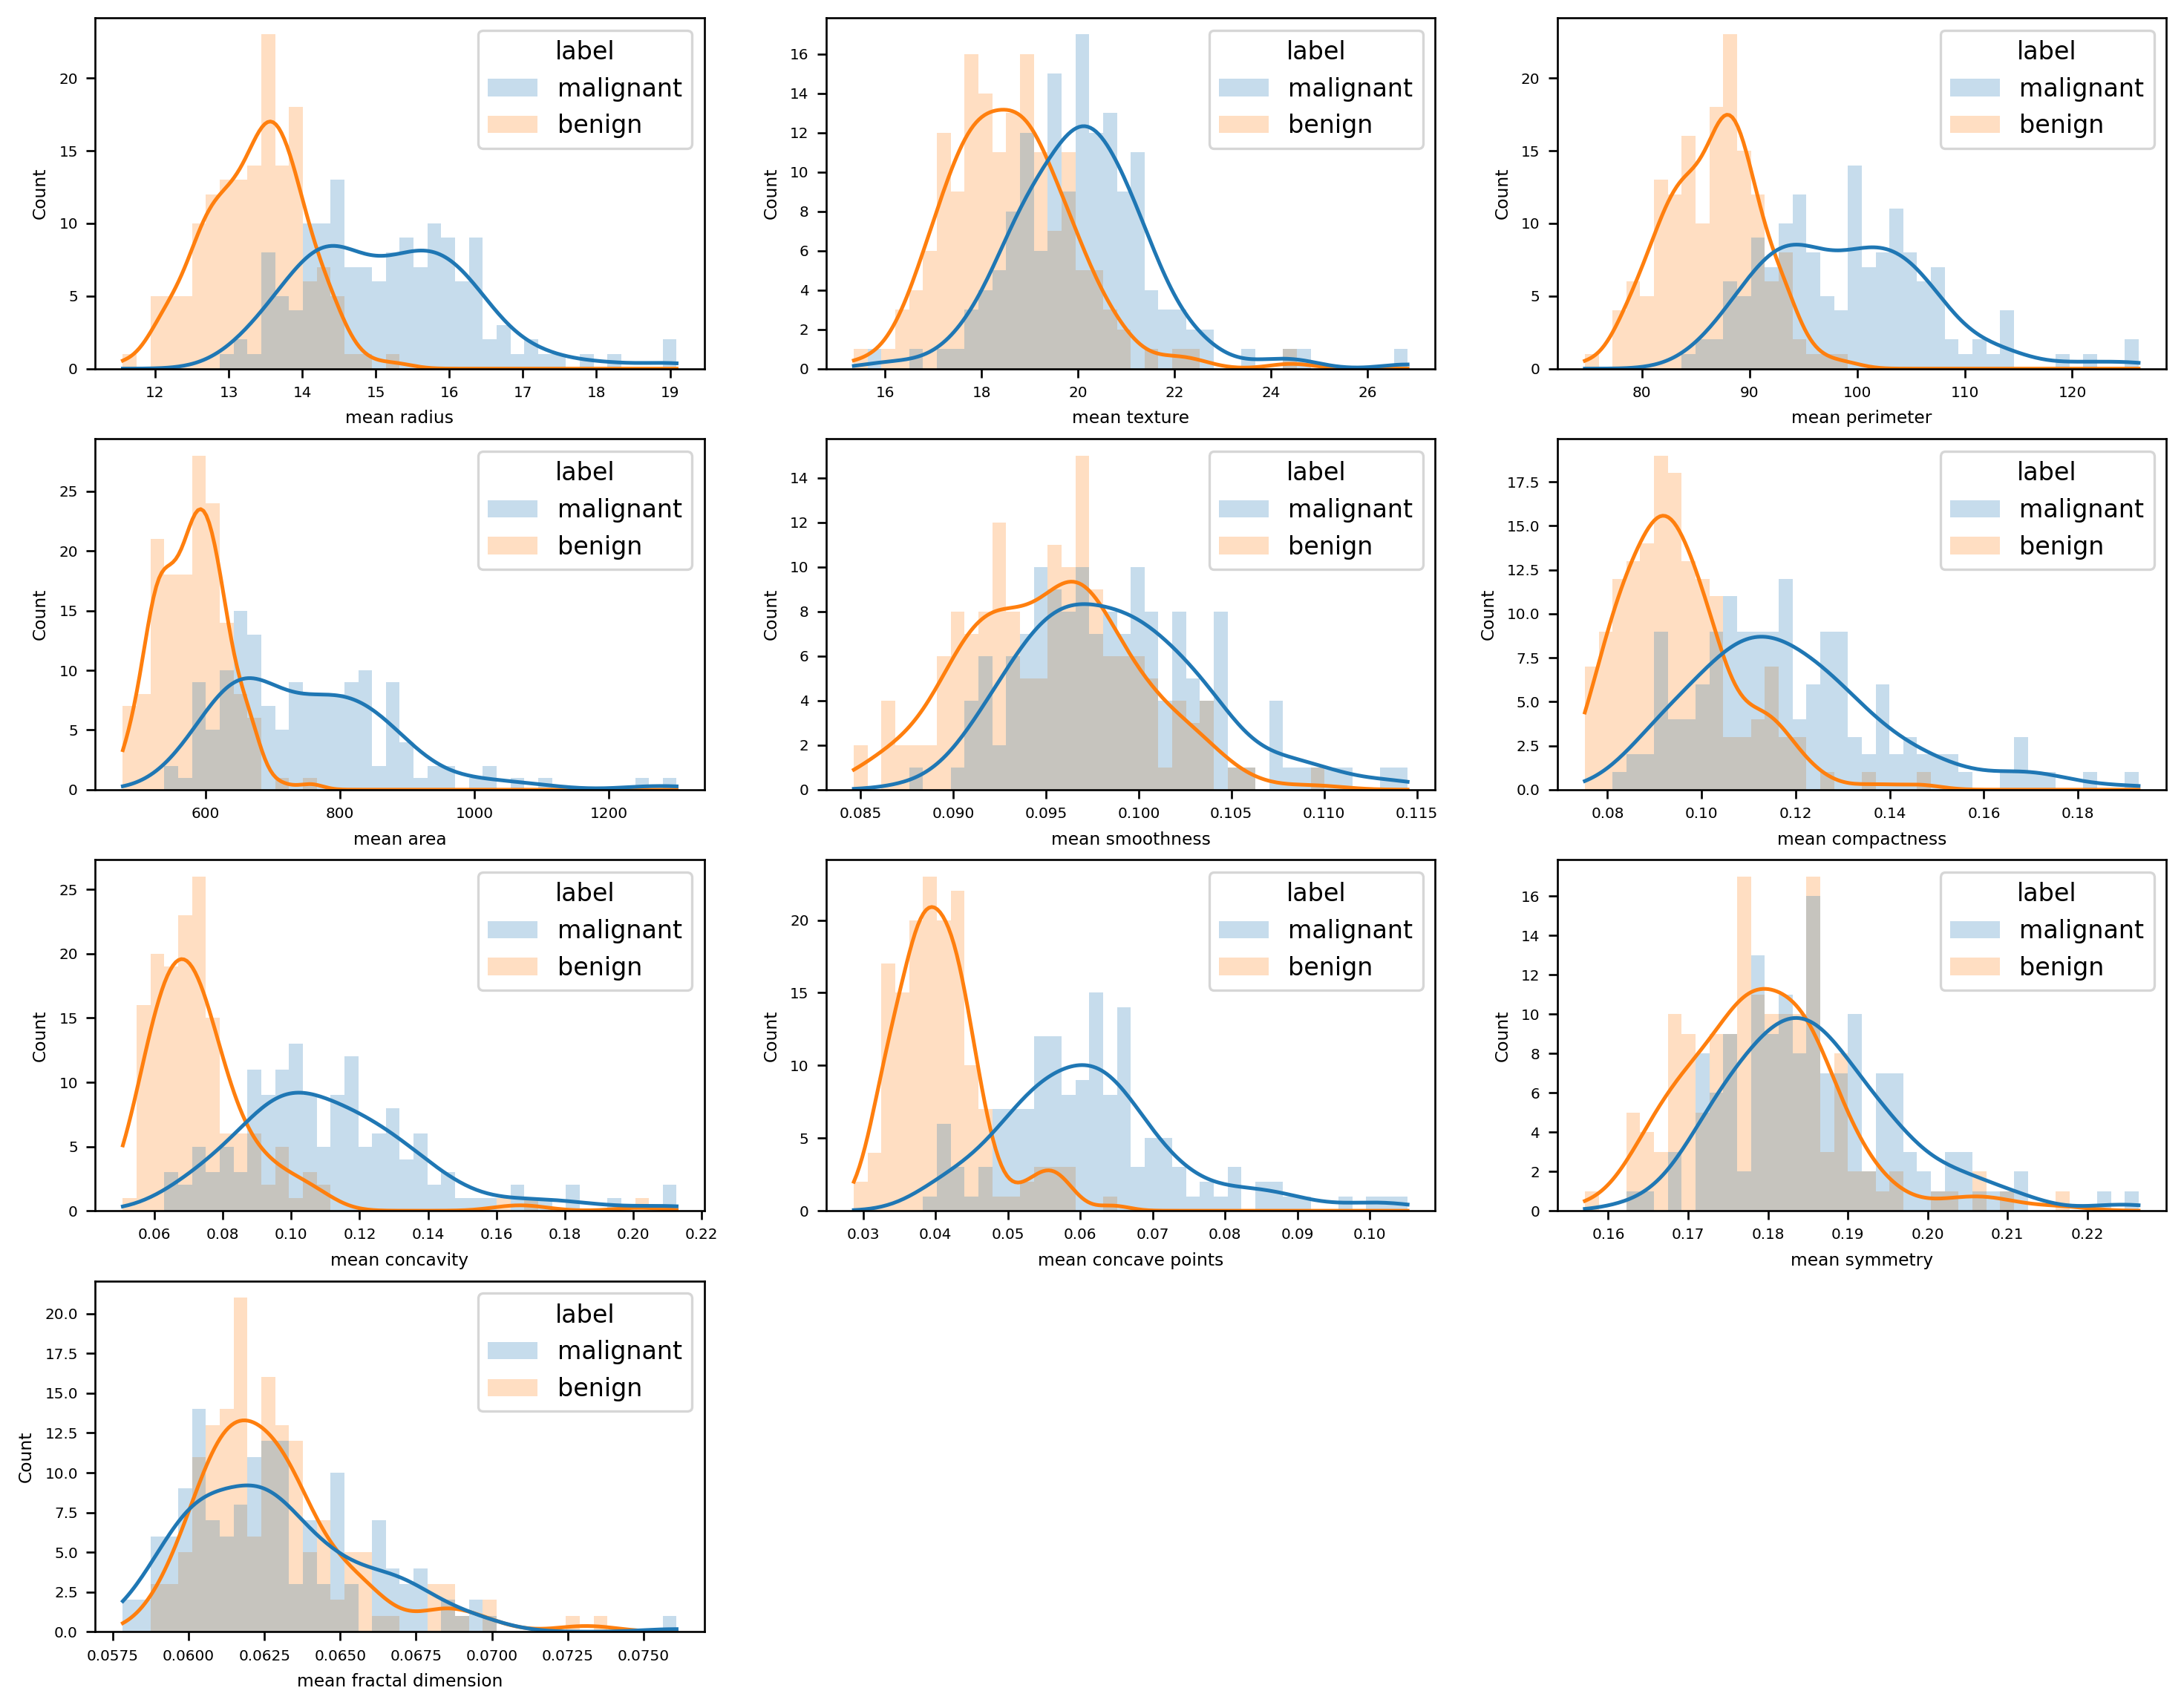

Histograms of Standard error group, having two claases displayed in one plot.


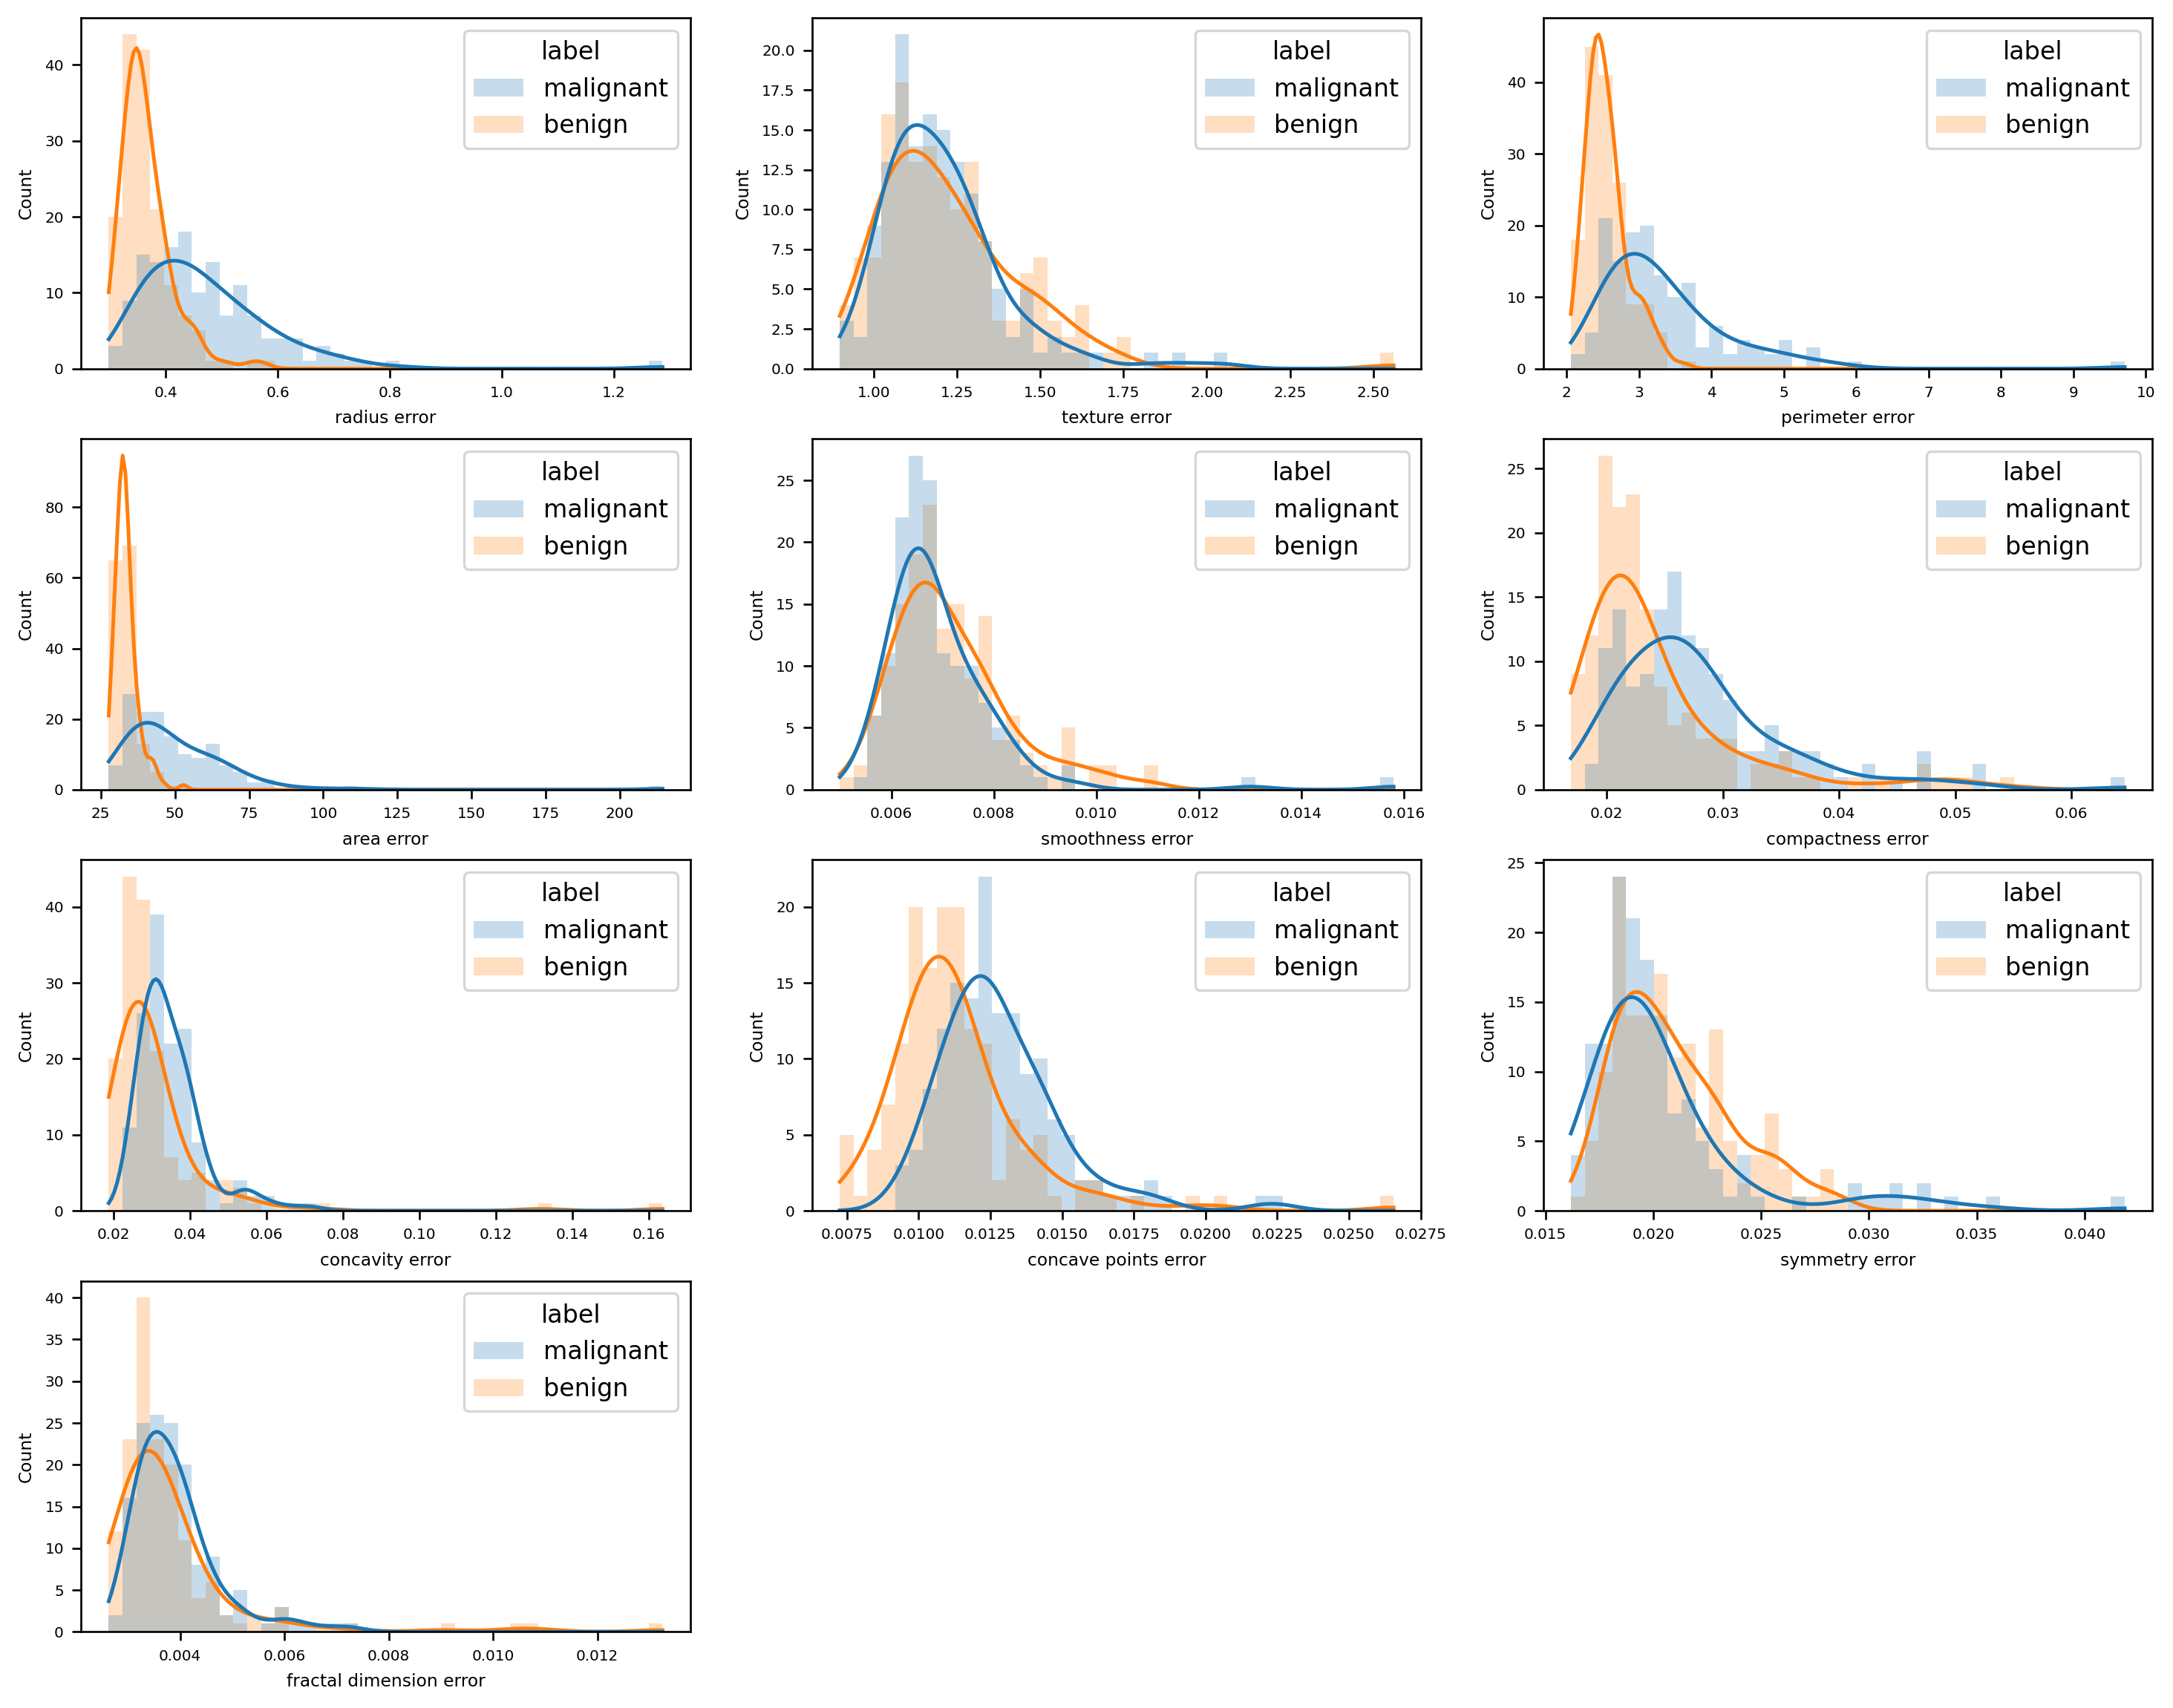

Histograms of Worst group, having two claases displayed in one plot.


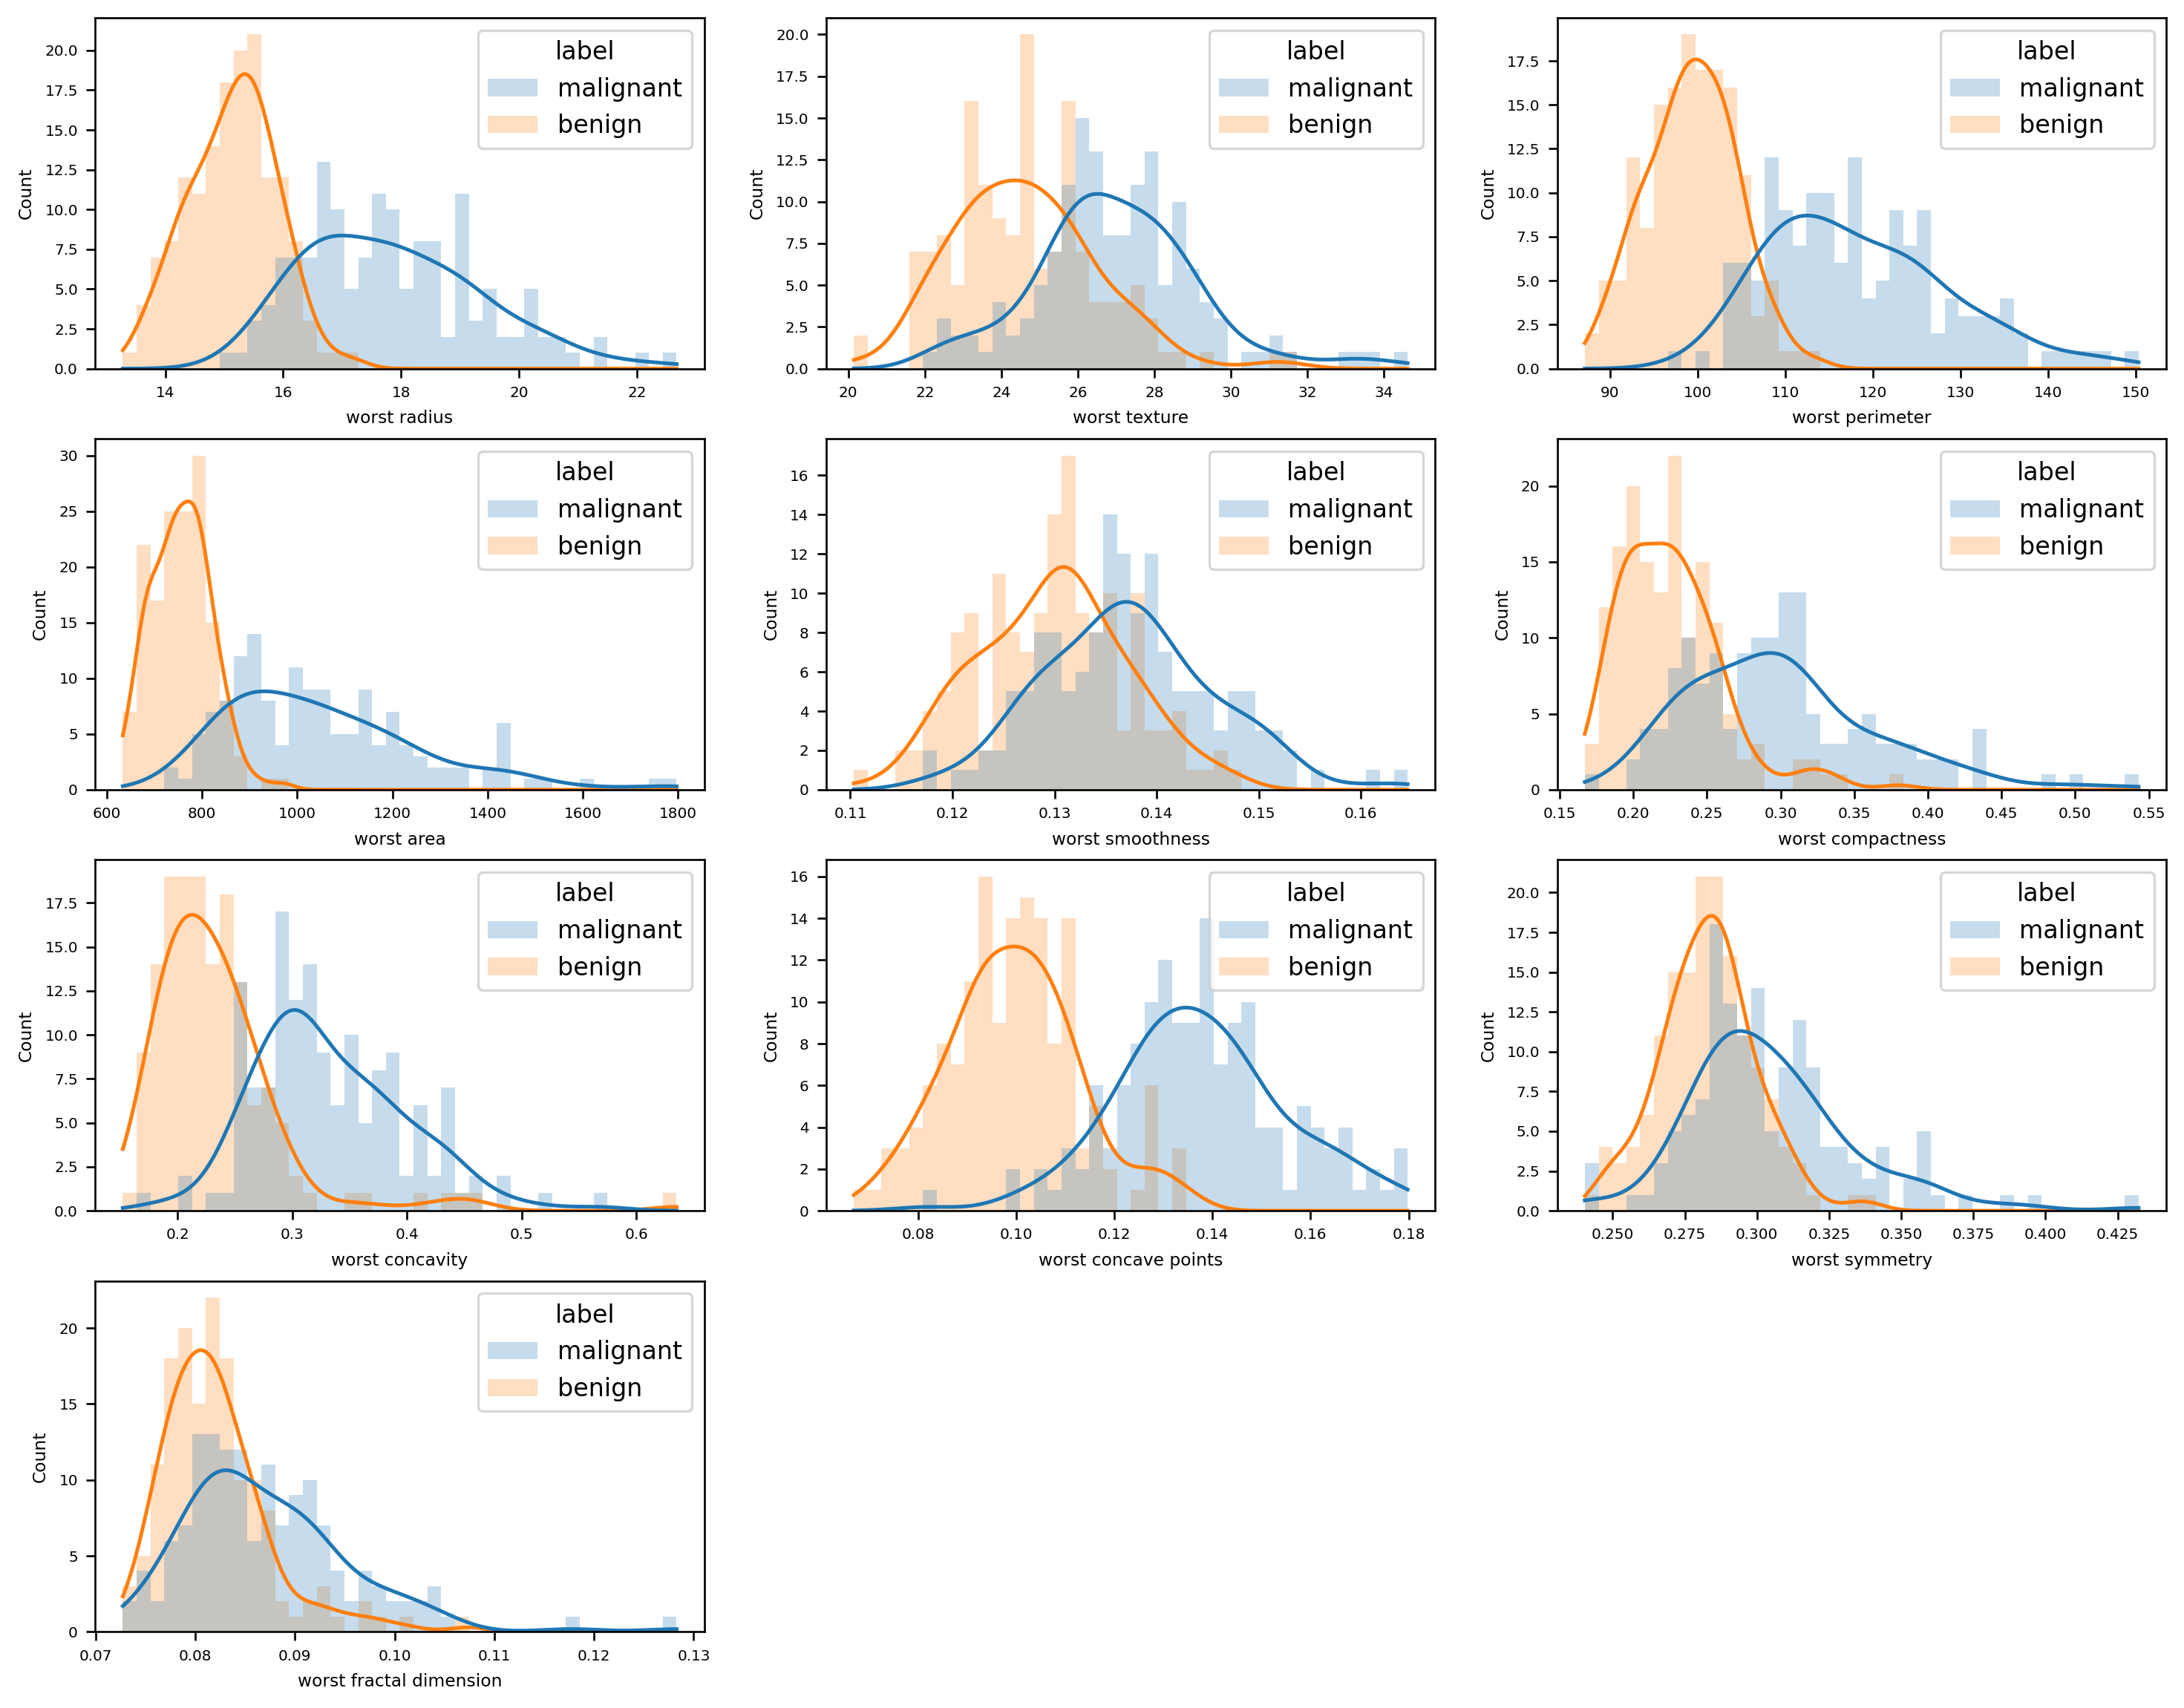

In [4]:
# Created a list containing all column names.
lst = list(df.columns)

# Remove the labels(y).
lst.remove("label")

# Created a list for mean group.
lst_mean = lst[:10]

# Created a list for standard error group.
lst_error = lst[10:20]

# Created a list for worst group.
lst_worst = lst[20:]

# Shows the histpgrams of each(3) gruops as per guidelines.
groups = [lst_mean,lst_error,lst_worst]

# Defined counter variable "c" for displaying each group.
for c,i in enumerate(groups):
    # Defined a figure size.
    plt.figure(figsize=(15,12))
    if c == 0:
        print(f"Histograms of Mean group, having two claases displayed in one plot.")
    if c == 1:
        print(f"Histograms of Standard error group, having two claases displayed in one plot.")
    if c == 2:
        print(f"Histograms of Worst group, having two claases displayed in one plot.")
    # Defined feature length, number rows, and number of columns for subplots.
    nfeat = len(i)
    ncol = 3
    nrow = int(np.ceil(nfeat/ncol))
    for n in range(nfeat):
        # Defined subplot configuration.
        plt.subplot(nrow,ncol,n+1)
        # Overlapping bars could be hard to visualise. Therefore applied step funtion.
        sns.histplot(data=df, x=i[n], hue="label", bins=40, kde=True, edgecolor=None, element="step")
    plt.show()

### 1.3 Ranking the features

In [5]:
print("By observing the histograms: \n The following are the 3 strongest features for discriminating between the classes/labels. \n 1) mean concave points \n 2) worst perimeter \n 3) worst radius")

By observing the histograms: 
 The following are the 3 strongest features for discriminating between the classes/labels. 
 1) mean concave points 
 2) worst perimeter 
 3) worst radius


### 1.4 Splitting the dataset

In [6]:
from sklearn.model_selection import train_test_split
# Split the data into 56-14-30% subsets(train-validate-test).
# Target variable is "label". Therefore, used label for stratify.
bigtrain_set, test_set = train_test_split(df, test_size=0.3, random_state=50, stratify=df["label"])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.2, random_state=50, stratify=bigtrain_set["label"])

# Check the proportion.
print("Label proportions in training data:")
print(train_set["label"].value_counts())
print()
print("Label proportions in validation data:")
print(val_set["label"].value_counts())
print()
print("Label proportions in testing data:")
print(test_set["label"].value_counts())
print()
print("You can see that in all sets, benign is having slight larger proportion than malignant due to the proportion difference in the original dataset.")

Label proportions in training data:
benign       86
malignant    82
Name: label, dtype: int64

Label proportions in validation data:
benign       22
malignant    20
Name: label, dtype: int64

Label proportions in testing data:
benign       46
malignant    44
Name: label, dtype: int64

You can see that in all sets, benign is having slight larger proportion than malignant due to the proportion difference in the original dataset.


## 2. Build, Train and Optimise Classifiers

### 2.1 Pipeline

In [7]:
from sklearn.impute import SimpleImputer

# Designed a pre-processing pipeline for missing value imputation and feature scaling.
pre_pipeline = Pipeline([ ('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler())])

### 2.2 Baseline measurements

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class

**For each case measure and display the following metrics:**
 - balanced accuracy
 - recall
 - precision
 - auc
 - f1score
 - fbeta_score with beta=0.1
 - fbeta_score with beta=10

In [8]:
from sklearn.metrics import fbeta_score, make_scorer

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

Case1:
Balanced Accuracy: 0.5
Recall is: 0.0
Precision is: 0.0
auc score is: 0.5
f1 score is: 0.0
fbeta score with beta = 0.1 is: 0.0
fbeta score with beta = 10 is: 0.0
Accuracy score(Confusion matrix) is: 0.5119047619047619


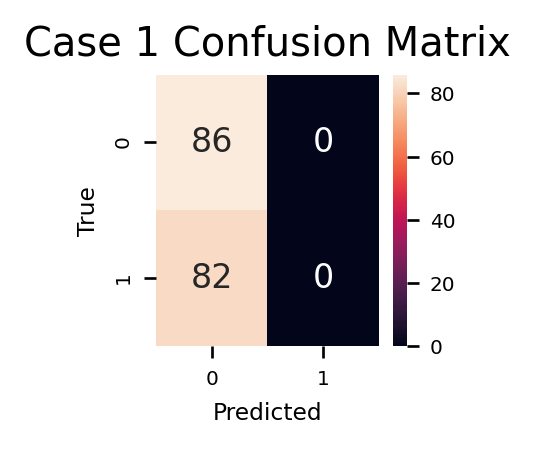


Case2:
Balanced Accuracy: 0.5
Recall is: 1.0
Precision is: 0.4880952380952381
auc score is: 0.5
f1 score is: 0.6559999999999999
fbeta score with beta = 0.1 is: 0.490581684634522
fbeta score with beta = 10 is: 0.9897227533460802
Accuracy score(Confusion matrix) is: 0.4880952380952381


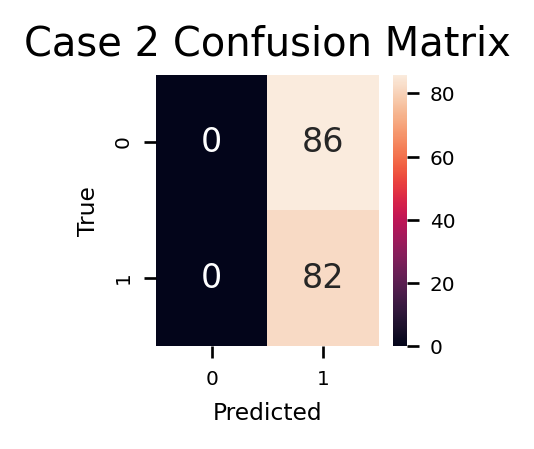


Case3:
Balanced Accuracy: 0.5473624503686898
Recall is: 0.5365853658536586
Precision is: 0.5365853658536586
auc score is: 0.5473624503686898
f1 score is: 0.5365853658536586
fbeta score with beta = 0.1 is: 0.5365853658536586
fbeta score with beta = 10 is: 0.5365853658536585
Accuracy score(Confusion matrix) is: 0.5476190476190477


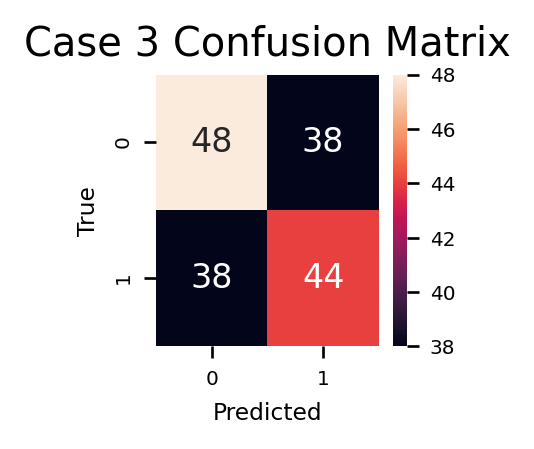

In [9]:
# Imported necessary libraries for evaluation of each case.
import random
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Separated features and target variable.
y_test = test_set.iloc[:,0] 
x_test = test_set.iloc[:,1:]
y_train = train_set.iloc[:,0] 
x_train = train_set.iloc[:,1:]
y_val = val_set.iloc[:,0] 
x_val = val_set.iloc[:,1:]

# Considered malignant as a positive case(1) and benign as a negative case(0).
y_train = y_train.replace("benign",0)
y_train = y_train.replace("malignant",1)
y_val = y_val.replace("benign",0)
y_val = y_val.replace("malignant",1)
y_test = y_test.replace("benign",0)
y_test = y_test.replace("malignant",1)

# Case 1 is containing all negative samples(0).
case1 = [0] * len(y_train)

# Case 2 is containing all positive samples(1).
case2 = [1] * len(y_train)

# Case 3 is containing equal probability of having negative or positive(0 or 1).
case3_list = [0,1]
# For equal chance of occurance, weighted both labels to 10-10(gave equal weights).
case3 = random.choices(case3_list,weights=(10,10),k=len(y_train))


print("Case1:")
print("Balanced Accuracy:",balanced_accuracy_score(y_train,case1))
print("Recall is:",recall_score(y_train,case1))
print("Precision is:",precision_score(y_train,case1,zero_division=0))
print("auc score is:",roc_auc_score(y_train,case1))
print("f1 score is:",f1_score(y_train,case1))
print("fbeta score with beta = 0.1 is:",f01_score(y_train,case1))
print("fbeta score with beta = 10 is:",f10_score(y_train,case1))
print("Accuracy score(Confusion matrix) is:",accuracy_score(y_train,case1))
plt.figure(figsize=(1.5,1.5))
cmat = confusion_matrix(y_true=y_train, y_pred=case1)
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Case 1 Confusion Matrix')
plt.show()
print()
print("Case2:")
print("Balanced Accuracy:",balanced_accuracy_score(y_train,case2))
print("Recall is:",recall_score(y_train,case2))
print("Precision is:",precision_score(y_train,case2,zero_division=0))
print("auc score is:",roc_auc_score(y_train,case2))
print("f1 score is:",f1_score(y_train,case2))
print("fbeta score with beta = 0.1 is:",f01_score(y_train,case2))
print("fbeta score with beta = 10 is:",f10_score(y_train,case2))
print("Accuracy score(Confusion matrix) is:",accuracy_score(y_train,case2))
plt.figure(figsize=(1.5,1.5))
cmat = confusion_matrix(y_true=y_train, y_pred=case2)
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Case 2 Confusion Matrix')
plt.show()
print()
print("Case3:")
print("Balanced Accuracy:",balanced_accuracy_score(y_train,case3))
print("Recall is:",recall_score(y_train,case3))
print("Precision is:",precision_score(y_train,case3,zero_division=0))
print("auc score is:",roc_auc_score(y_train,case3))
print("f1 score is:",f1_score(y_train,case3))
print("fbeta score with beta = 0.1 is:",f01_score(y_train,case3))
print("fbeta score with beta = 10 is:",f10_score(y_train,case3))
print("Accuracy score(Confusion matrix) is:",accuracy_score(y_train,case3))
plt.figure(figsize=(1.5,1.5))
cmat = confusion_matrix(y_true=y_train, y_pred=case3)
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Case 3 Confusion Matrix')
plt.show()

### 2.3 Choose a performance metric

In [10]:

print("Client's requirements: \n 1) Identify positive cases(malignant cancer). \n 2) Minimize the false positive cases. \n My preferred performance metrics: \n 1) AUC : Shows the performance of the model at distinguishing between the positive and negative classes.(Includes 1st requirement) \n 2) fbeta (0.1) : Refers to the more weight in precision and less weight in recall.(Includes 2nd requirement)")

Client's requirements: 
 1) Identify positive cases(malignant cancer). 
 2) Minimize the false positive cases. 
 My preferred performance metrics: 
 1) AUC : Shows the performance of the model at distinguishing between the positive and negative classes.(Includes 1st requirement) 
 2) fbeta (0.1) : Refers to the more weight in precision and less weight in recall.(Includes 2nd requirement)


### 2.4 SGD baseline

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss

# Applied SGD model with case3(stronger baseline).
sgd_pl = Pipeline([ ('prepipe',pre_pipeline), ('sgd',SGDClassifier(loss='log_loss'))])
sgd_pl.fit(x_train,case3)
y_val_pred = sgd_pl.predict(x_test)
y_val_prob = sgd_pl.predict_proba(x_test)
y_val_prob = y_val_prob[:,1] 

print("auc score is:",roc_auc_score(y_val_pred,y_test))
print("accuracy is:",accuracy_score(y_val_pred,y_test))
print("fbeta score with beta = 0.1 is:",f01_score(y_val_pred,y_test))

auc score is: 0.7782738095238094
accuracy is: 0.7777777777777778
fbeta score with beta = 0.1 is: 0.75033768572715


### 2.5 Confusion matrix 

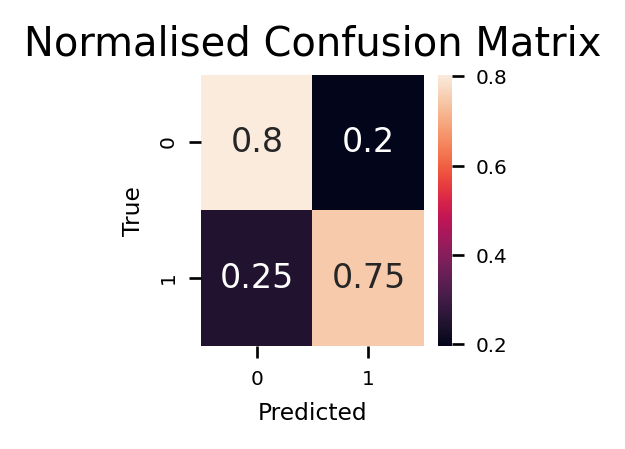

In [12]:
cmat = confusion_matrix(y_true=y_test, y_pred=y_val_pred, normalize="true")
plt.figure(figsize=(1.5,1.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

In [13]:
print("Probability of person having malignant cancer with no cancer in test: 0.25")
print("None of the requirements are satisfied. Therefore, this baseline is not sufficient.")

Probability of person having malignant cancer with no cancer in test: 0.25
None of the requirements are satisfied. Therefore, this baseline is not sufficient.


### 2.6 Main classifier

**Train and optimise the hyperparameters** to give the best performance for **each of the following classifiers**:
 - KNN (K-Nearest Neighbour) classifier
 - Decision tree classifier
 - Support vector machine classifier
 - SGD classifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Implemented knn classifier without optimization.
print("KNN Implementation:")
knn_pl = Pipeline([ ('prepipe',pre_pipeline), ('knn',KNeighborsClassifier())])
knn_pl.fit(x_train,y_train)
print("Validation:")
y_val_pred = knn_pl.predict(x_val)
knn_acc = accuracy_score(y_true = y_val, y_pred = y_val_pred)
print(f'Accuracy for KNN is {knn_acc}')
roc = roc_auc_score(y_val,y_val_pred)
print("ROC score is:",roc)
print("Testing:")
y_test_pred = knn_pl.predict(x_test)
knn_acc = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for KNN is {knn_acc}')
knn_roc = roc_auc_score(y_test,y_test_pred)
print("ROC score is:",knn_roc)
print()

# Implemented Decision Tree classifier without optimization.
from sklearn.tree import DecisionTreeClassifier
print("Decision Tree Implementation:")
dt_pl = Pipeline([ ('prepipe',pre_pipeline), ('dt',DecisionTreeClassifier())])
dt_pl.fit(x_train,y_train)
print("Validation:")
y_val_pred = dt_pl.predict(x_val)
dt_acc = accuracy_score(y_true = y_val, y_pred = y_val_pred)
print(f'Accuracy for Decision Tree is {dt_acc}')
roc = roc_auc_score(y_val,y_val_pred)
print("ROC score is:",roc)
print("Testing:")
y_test_pred = dt_pl.predict(x_test)
dt_acc = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for Decision Tree is {dt_acc}')
dt_roc = roc_auc_score(y_test, y_test_pred)
print("ROC score is:",dt_roc)
print()

# Implemented SVM classifier without optimization.
from sklearn.svm import SVC
print("SVM Implementation:")
svm_pl = Pipeline([ ('prepipe',pre_pipeline), ('svm',SVC(kernel="rbf"))])
svm_pl.fit(x_train,y_train)
print("Validation:")
y_val_pred = svm_pl.predict(x_val)
svm_acc = accuracy_score(y_true = y_val, y_pred = y_val_pred)
print(f'Accuracy for SVM is {svm_acc}')
roc = roc_auc_score(y_val, y_val_pred)
print("ROC score is:",roc)
print("Testing:")
y_test_pred = svm_pl.predict(x_test)
svm_acc = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for SVM is {svm_acc}')
svm_roc = roc_auc_score(y_test, y_test_pred)
print("ROC score is:",svm_roc)
print()

# Implemented SGD classifier without optimization.
print("SGD Implementation:")
sgd_pl = Pipeline([ ('prepipe',pre_pipeline), ('sgd',SGDClassifier())])
sgd_pl.fit(x_train,y_train)
print("Validation:")
y_val_pred = sgd_pl.predict(x_val)
sgd_acc = accuracy_score(y_true = y_val, y_pred = y_val_pred)
print(f'Accuracy for SGD is {sgd_acc}')
roc = roc_auc_score(y_val, y_val_pred)
print("ROC score is:",roc)
print("Testing:")
y_test_pred = sgd_pl.predict(x_test)
sgd_acc = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for SGD is {sgd_acc}')
sgd_roc = roc_auc_score(y_test, y_test_pred)
print("ROC score is:",sgd_roc)
print()


# Defined a parameter grid for hyperparameters Number of neighbors and Weight.
print("KNN Optimization:")
parameters = {'knn__n_neighbors':[3,5,10,20,30,50], 'knn__weights':['uniform','distance']}
gridcv_knn = GridSearchCV(knn_pl, parameters, cv=10, scoring='neg_root_mean_squared_error')
gridcv_knn.fit(x_train, y_train)
print(f'Best score is {-gridcv_knn.best_score_} for best params of {gridcv_knn.best_params_}') 

# Applied the best configration/setting of hyperparameters and feed the KNN model. Evaluated a tuned KNN model with Accuracy and ROC score.
gridcv_knn.best_estimator_.fit(np.concatenate((x_train,x_val)),np.concatenate((y_train,y_val)))
print("Testing:")
y_test_pred = gridcv_knn.best_estimator_.predict(x_test.values)
knn_acc_opt = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for KNN is {knn_acc_opt}')
knn_roc_opt = roc_auc_score(y_test, y_test_pred)
print("ROC score is:",knn_roc_opt)
print()

# Defined a parameter grid for hyperparameters Criterion and Max depth.
print("Decision Tree Optimization:")
parameters = {'dt__criterion':['gini','entropy'], 'dt__max_depth':[2,4,6,8,10,12]}
gridcv_dt = GridSearchCV(dt_pl, parameters, cv=10, scoring='neg_root_mean_squared_error')
gridcv_dt.fit(x_train, y_train)
print(f'Best score is {-gridcv_dt.best_score_} for best params of {gridcv_dt.best_params_}') 

# Applied the best configration/setting of hyperparameters and feed the Decision Tree model. Evaluated a tuned Decision Tree model with Accuracy and ROC score.
gridcv_dt.best_estimator_.fit(np.concatenate((x_train,x_val)),np.concatenate((y_train,y_val)))
print("Testing:")
y_test_pred = gridcv_dt.best_estimator_.predict(x_test.values)
dt_acc_opt = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for Decision Tree is {dt_acc_opt}')
dt_roc_opt = roc_auc_score(y_test,y_test_pred)
print("ROC score is:",dt_roc_opt)
print()

# Defined a parameter grid for hyperparameters C and Gamma.
print("SVM Optimization:")
parameters = {'svm__C':[0.1,1,10,50,100,500,1000],'svm__gamma':[0.1,0.01,0.001,1]}
gridcv_svm = GridSearchCV(svm_pl, parameters, cv=10, scoring='neg_root_mean_squared_error')
gridcv_svm.fit(x_train, y_train)
print(f'Best score is {-gridcv_svm.best_score_} for best params of {gridcv_svm.best_params_}') 

# Applied the best configration/setting of hyperparameters and feed the SVM model. Evaluated a tuned SVM model with Accuracy and ROC score.
gridcv_svm.best_estimator_.fit(np.concatenate((x_train,x_val)),np.concatenate((y_train,y_val)))
print("Testing:")
y_test_pred = gridcv_svm.best_estimator_.predict(x_test.values)
svm_acc_opt = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for SVC is {svm_acc_opt}')
svm_roc_opt = roc_auc_score(y_test,  y_test_pred)
print("ROC score is:",svm_roc_opt)
print()

# Defined a parameter grid for hyperparameters Loss and Alpha.
print("SGD Optimization:")
parameters = {'sgd__loss':['hinge','log_loss'], 'sgd__alpha':[0.1,0.01,0.001,1]}
gridcv_sgd = GridSearchCV(sgd_pl, parameters, cv=10, scoring='neg_root_mean_squared_error')
gridcv_sgd.fit(x_train, y_train)
print(f'Best score is {-gridcv_sgd.best_score_} for best params of {gridcv_sgd.best_params_}') 

# Applied the best configration/setting of hyperparameter and feed the SGD model. Evaluated a tuned SGD model with Accuracy, and ROC score.
gridcv_sgd.best_estimator_.fit(np.concatenate((x_train,x_val)),np.concatenate((y_train,y_val)))
print("Testing:")
y_test_pred = gridcv_sgd.best_estimator_.predict(x_test.values)
sgd_acc_opt = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for SGD is {sgd_acc_opt}')
sgd_roc_opt = roc_auc_score( y_test,y_test_pred)
print("ROC score is:",sgd_roc_opt)
print()

# Imported tabulate to create table summary.
from tabulate import tabulate

# Table for each model accuracies.
data_accuracy = [["KNN", knn_acc, knn_acc_opt,gridcv_knn.best_params_],
        ["Decision Tree",dt_acc,dt_acc_opt,gridcv_dt.best_params_],
        ["SVM",svm_acc,svm_acc_opt,gridcv_svm.best_params_],
        ["SGD",sgd_acc,sgd_acc_opt,gridcv_sgd.best_params_]
]
cols = ["Model","Testing Acc."," Testing Acc.(Optimized model)","Best params"]
print(tabulate(data_accuracy, headers=cols, tablefmt="fancy_grid",showindex="always"))

# Table for each model ROC scores.
data_roc = [["KNN", knn_roc, knn_roc_opt,gridcv_knn.best_params_],
        ["Decision Tree", dt_roc, dt_roc_opt,gridcv_dt.best_params_],
        ["SVM", svm_roc, svm_roc_opt,gridcv_svm.best_params_],
        ["SGD", sgd_roc, sgd_roc_opt,gridcv_sgd.best_params_]
]
cols = ["Model","Testing ROC"," Testing ROC(Optimized model)","Best params"]
print(tabulate(data_roc, headers=cols, tablefmt="fancy_grid",showindex="always"))

KNN Implementation:
Validation:
Accuracy for KNN is 0.9761904761904762
ROC score is: 0.9772727272727273
Testing:
Accuracy for KNN is 0.9666666666666667
ROC score is: 0.966403162055336

Decision Tree Implementation:
Validation:
Accuracy for Decision Tree is 0.8809523809523809
ROC score is: 0.8795454545454546
Testing:
Accuracy for Decision Tree is 0.9
ROC score is: 0.900197628458498

SVM Implementation:
Validation:
Accuracy for SVM is 0.9761904761904762
ROC score is: 0.9772727272727273
Testing:
Accuracy for SVM is 0.9666666666666667
ROC score is: 0.9668972332015812

SGD Implementation:
Validation:
Accuracy for SGD is 0.9523809523809523
ROC score is: 0.9522727272727273
Testing:
Accuracy for SGD is 0.9333333333333333
ROC score is: 0.932806324110672

KNN Optimization:
Best score is 0.18131396704303496 for best params of {'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
Testing:
Accuracy for KNN is 0.9333333333333333
ROC score is: 0.932806324110672

Decision Tree Optimization:
Best score is

In [16]:
print("By observing the both tables, following 3 are the best classifiers for this dataset: \n 1) SVM \n 2) SGD \n 3) KNN ")

By observing the both tables, following 3 are the best classifiers for this dataset: 
 1) SVM 
 2) SGD 
 3) KNN 


### 2.7 Model selection

In [17]:
print("In my perception: \n SVM is the best classifier with",gridcv_svm.best_params_)
'''The SVM model performed well with both validation-set and test-set. Furthermore, SVM model is having highest values in both Accuracy and ROC score. Moreover, This dataset is having very small records and high number of features, SVM model is very suitable for small and high dimensional data. Therefore, I have selected SVM model.'''

In my perception: 
 SVM is the best classifier with {'svm__C': 10, 'svm__gamma': 0.01}


'The SVM model performed well with both validation-set and test-set. Furthermore, SVM model is having highest values in both Accuracy and ROC score. Moreover, This dataset is having very small records and high number of features, SVM model is very suitable for small and high dimensional data. Therefore, I have selected SVM model.'

### 2.8 Final performance

Testing:
Accuracy for SVC is 0.9666666666666667
ROC score is: 0.966403162055336


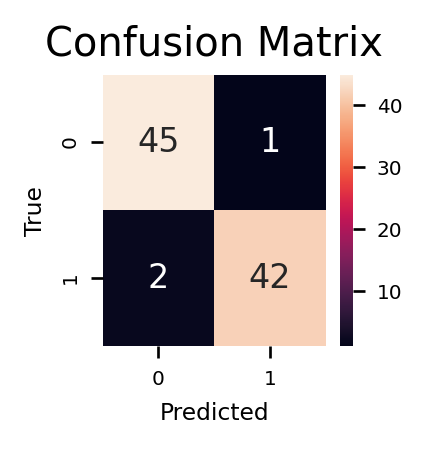

In [18]:
# Implemented Optimized SVM model
gridcv_svm.best_estimator_.fit(np.concatenate((x_train,x_val)),np.concatenate((y_train,y_val)))
print("Testing:")
y_test_pred = gridcv_svm.best_estimator_.predict(x_test.values)
svm_acc = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for SVC is {svm_acc}')
roc = roc_auc_score(y_test,  y_test_pred)
print("ROC score is:",roc)

# Confusion matrix for summary.
cmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
plt.figure(figsize=(1.5,1.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
print("1) Model accuracy with both positive and negative cases: 0.97 \n 2) MOdel accuracy with predicting positive cases: 0.95 \n 3) Clients require 1 in 10 false positive ratio: Model is having 0.45 in 10 false positive ratio")
print("Hence, model is satisfying the 2nd criteria of no more than 1 in 10 healthy cases labelled as positive")

1) Model accuracy with both positive and negative cases: 0.97 
 2) MOdel accuracy with predicting positive cases: 0.95 
 3) Clients require 1 in 10 false positive ratio: Model is having 0.45 in 10 false positive ratio
Hence, model is satisfying the 2nd criteria of no more than 1 in 10 healthy cases labelled as positive


## 3. Decision Boundaries

### 3.1 Rank features

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

In [20]:
# Defined both types.
type1 = df[df["label"] == "malignant"]
type2 = df[df["label"] == "benign"]

# Created a list of all features
feature_list = list(df.columns)
feature_list.remove("label")

y = df["label"]
y = y.replace("benign",0)
y = y.replace("malignant",1)

# list for features
feat = []
# list for relative t-score of feature
score = []

for i in feature_list:
    # used abs function because t-score is not affected by postive or negative sign.
    t = abs((type2[i].mean() - type1[i].mean()) / (0.5*(type1[i].std()+type1[i].std())))
    # prints the t-score value of each  feature.
    #print(f'T-score for {i} is {t}')
    feat.append(i)
    score.append(t)

# Created a dictionary having features with relative t-scores
dict1 = dict(zip(feat,score))

# Selected top 4 features.
print("Top 4 features according to T-score:")
top_features = sorted(dict1, key=dict1.get, reverse=True)[:4]
top_features

Top 4 features according to T-score:


['worst concave points',
 'worst perimeter',
 'worst radius',
 'mean concave points']

### 3.2 Visualise decision boundaries

In [21]:
def make_meshgrid(x, y, ns=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on (only min and max used)
    y: data to base y-axis meshgrid on (only min and max used)
    ns: number of steps in grid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    hx = (x_max - x_min)/ns
    hy = (y_max - y_min)/ns
    xx, yy = np.meshgrid(np.arange(x_min, x_max + hx, hx), np.arange(y_min, y_max + hy, hy))
    return xx, yy

In [22]:
def plot_contours(clf, xx, yy, xmean, n1, n2, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    xmean : 1d array of mean values (to populate constant features with)
    n1, n2: index numbers of features that change (for xx and yy)
    params: dictionary of params to pass to contourf, optional
    """
    # The following lines makes an MxN matrix to pass to the classifier (# samples x # features)
    # It does this by multiplying Mx1 and 1xN matrices, where the former is filled with 1's
    #  where M is the number of grid points in xx and N is the number of features in xmean
    #  It is done in such a way that the xmean vector is replaced in each row
    fullx = np.ones((xx.ravel().shape[0],1)) * np.reshape(xmean,(1,-1))
    fullx[:,n1] = xx.ravel()
    fullx[:,n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

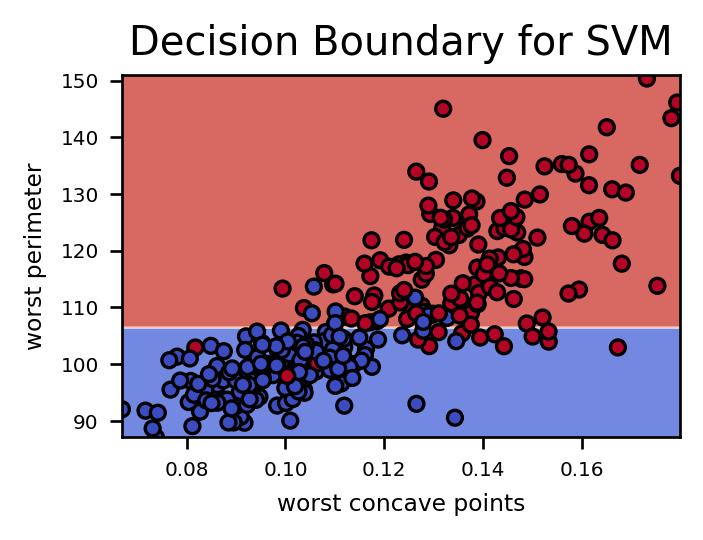

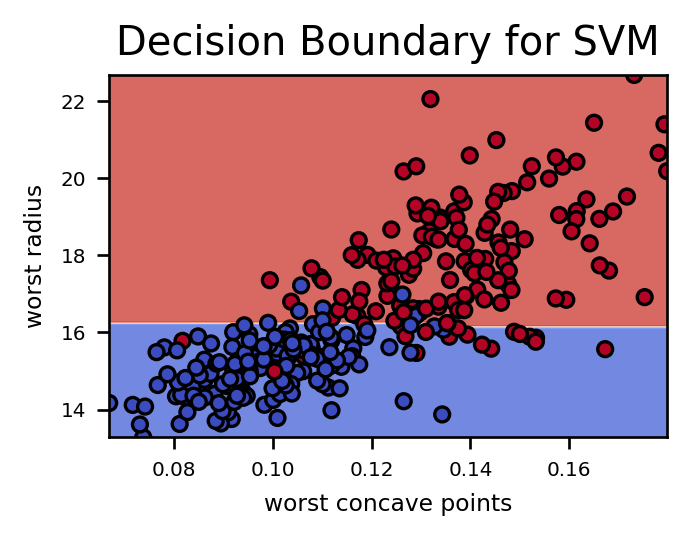

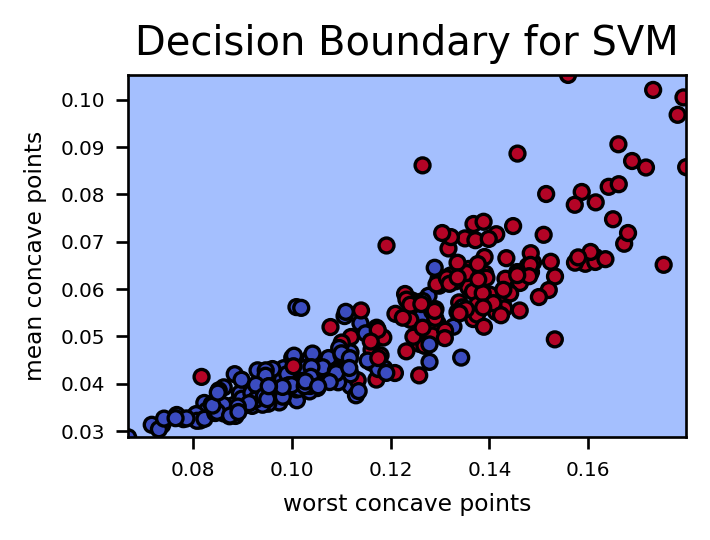

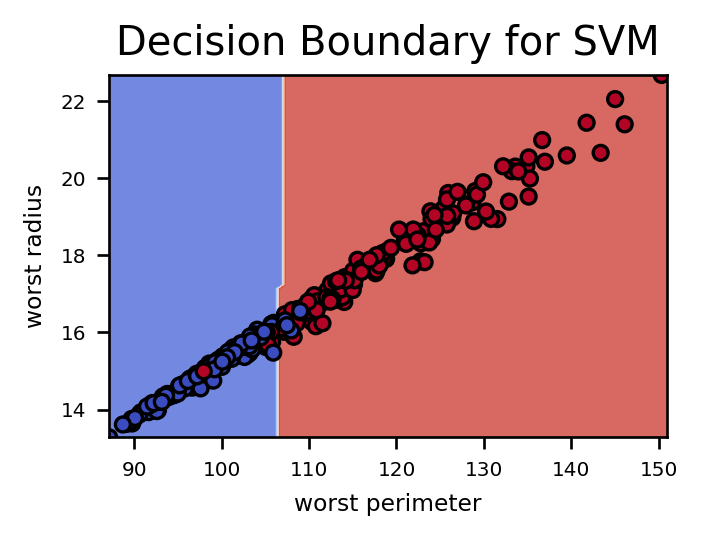

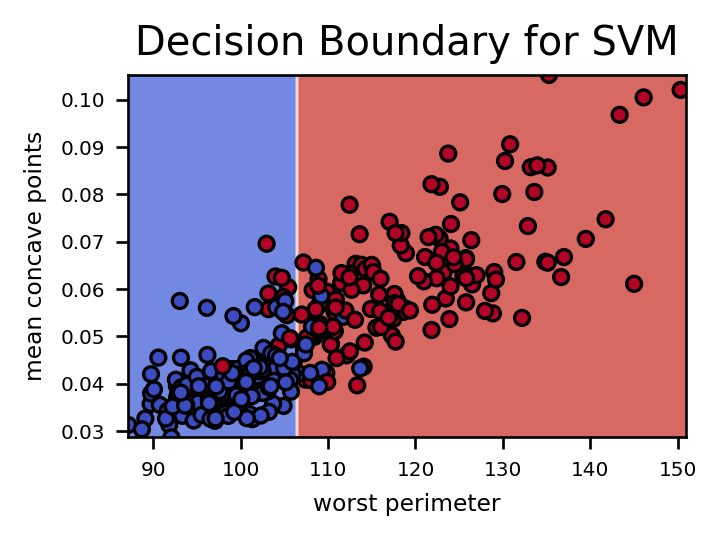

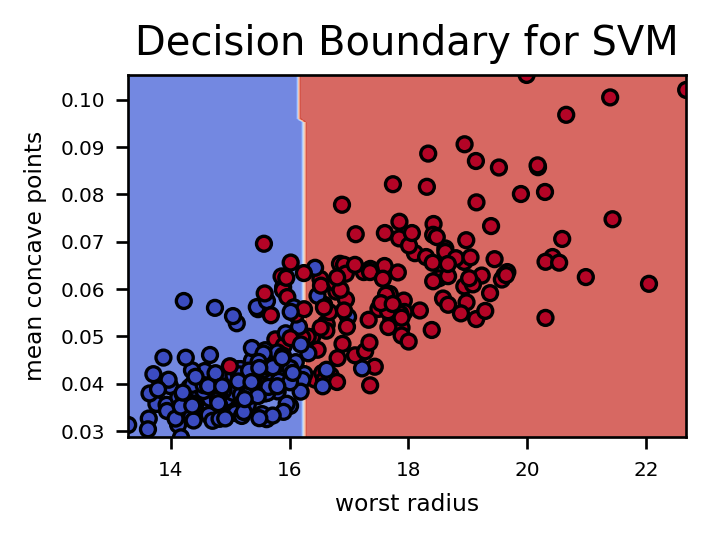

In [23]:
# created a list containing all different pairs of 4 most importance features.
imp_features = []
for i in top_features:
    for j in top_features:
        if i !=j and ([i,j] not in imp_features and [j,i] not in imp_features):
            imp_features.append([i,j])  

for i in imp_features:
    plt.figure(figsize=(3,2))
    x = df[i]
    xa = x.to_numpy()
    ya = y.to_numpy()
    hx = (xa[:,0].max() - xa[:,0].min())/100
    hy = (xa[:,1].max() - xa[:,1].min())/100
    a = np.arange(start=xa[:,0].min(), stop=xa[:,0].max()+hx, step=hx)
    b = np.arange(start=xa[:,1].min(), stop=xa[:,1].max()+hy, step=hy)
    xx,yy = np.meshgrid(a,b)
    svm = SVC(C=10,gamma=0.01)
    svm.fit(xa,ya)
    inputarr = np.array([xx.ravel(),yy.ravel()]).T
    labels = svm.predict(inputarr)
    plt.contourf(xx,yy,labels.reshape(xx.shape),cmap=plt.cm.coolwarm,alpha=0.8)
    plt.scatter(xa[:,0],xa[:,1],c=ya,cmap=plt.cm.coolwarm, s=20,edgecolors="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(i[0])
    plt.ylabel(i[1])
    plt.title("Decision Boundary for SVM")
    plt.show()

### 3.3 Interpretation

In [24]:
'''By observing the decision boundaries above, method concluded as well/good. The decision boundary of between each features is visible and separate the labels good enough except the case of worst concave points vs mean concave points.'''

'By observing the decision boundaries above, method concluded as well/good. The decision boundary of between each features is visible and separate the labels good enough except the case of worst concave points vs mean concave points.'

## 4. Second Round 

After presenting your initial results to the client they come back to you and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

### 4.1 New estimate

Performance after removing worst groups
Validation:
Accuracy for SVM is 0.9285714285714286
Testing:
Accuracy for SVM is 0.9333333333333333


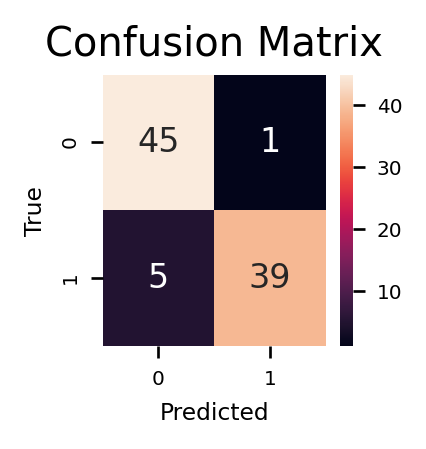

In [25]:
# Removed worst group
x_train = train_set.iloc[:,1:21]
x_test = test_set.iloc[:,1:21]
x_val = val_set.iloc[:,1:21]

# Implemented optimised SVM model.
pre_pipeline1 = Pipeline([ ('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler())])
opsvm_pl = Pipeline([ ('prepipe',pre_pipeline1), ('svm',SVC(C=10, gamma=0.01,kernel="rbf"))])
opsvm_pl.fit(x_train,y_train)
print("Performance after removing worst groups")
print("Validation:")
y_val_pred = opsvm_pl.predict(x_val)
svm_acc = accuracy_score(y_true = y_val, y_pred = y_val_pred)
print(f'Accuracy for SVM is {svm_acc}')
print("Testing:")
y_test_pred = opsvm_pl.predict(x_test)
svm_acc = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f'Accuracy for SVM is {svm_acc}')

# Confusion matrix for summary.
cmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
plt.figure(figsize=(1.5,1.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 4.2 Performance difference

In [26]:
'''Answer: Worse than the previous classifier'''
print("Please consider the term 'previous model' is the model before removing the worst group and the term 'new model' is the model after removing the worst group.")
print()
print("Reasons:")
print("1) 3 out of 4 most-important features are from the worst group according to the T-score. Hence, the performance of new model is expected to be lower than the previous model.")
print()
print("2) The new model exceeds the clients's 2nd requirement of having no more than 1 in 10 healty cases labelled as positive. New model is having 1.13 in 10 healty cases labelled as postive.")
print()
print("3) 2 out of 3 discrimitating features are from the worst group according to the analysis of Q 1.2. Therefore, performance of new model is lower than the previous model.")

Please consider the term 'previous model' is the model before removing the worst group and the term 'new model' is the model after removing the worst group.

Reasons:
1) 3 out of 4 most-important features are from the worst group according to the T-score. Hence, the performance of new model is expected to be lower than the previous model.

2) The new model exceeds the clients's 2nd requirement of having no more than 1 in 10 healty cases labelled as positive. New model is having 1.13 in 10 healty cases labelled as postive.

3) 2 out of 3 discrimitating features are from the worst group according to the analysis of Q 1.2. Therefore, performance of new model is lower than the previous model.
